# v2.2 exploration trying to make it work better

In [9]:
# Environment
import os
import os.path as osp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
# Local modules
sys.path.append('..')
import reproducibility
import pandas as pd
from utils import print_dict_summary
from data_funcs import rmse, build_train_dict, combine_nested, subset_by_features
# from moisture_rnn import RNNParams, RNNData, RNN, RNN_LSTM, rnn_data_wrap
from moisture_rnn_pkl import pkl2train
from tensorflow.keras.callbacks import Callback
from utils import hash2
import copy
import logging
import pickle
from utils import logging_setup, read_yml, read_pkl, hash_ndarray, hash_weights, str2time
import yaml
import copy
import time

In [10]:
logging_setup()

## Test Data

In [11]:
file_paths = ['data/fmda_rocky_202403-05_f05.pkl']

In [12]:
# Params used for data filtering
params_data = read_yml("params_data.yaml") 
params_data

{'max_intp_time': 10,
 'zero_lag_threshold': 10,
 'hours': 720,
 'min_fm': 1,
 'max_fm': 90,
 'min_rain': 0,
 'max_rain': 100,
 'min_wind': 0,
 'max_wind': 35,
 'min_solar': 0,
 'max_solar': 1400,
 'min_soilm': 0,
 'features_all': ['Ed',
  'Ew',
  'solar',
  'wind',
  'elev',
  'lon',
  'lat',
  'soilm',
  'canopyw',
  'groundflux',
  'rain']}

In [13]:
dat = read_pkl(file_paths[0])

loading file data/fmda_rocky_202403-05_f05.pkl


In [14]:
import importlib
import data_funcs
importlib.reload(data_funcs)
from data_funcs import build_train_dict

In [15]:
params_data.update({'hours': None})

In [16]:
train3 = build_train_dict(file_paths, params_data, spatial=False, forecast_step=3, drop_na=True)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Extracting data from input file data/fmda_rocky_202403-05_f05.pkl
loading file data/fmda_rocky_202403-05_f05.pkl
2024-10-21 11:27:35,248 - INFO - CPTC2_202403 HRRR.time time array increments are 1.0 hours
2024-10-21 11:27:35,275 - INFO - CPTC2 RAWS.time_raws time array increments are min 1.0 max 2.0
Shifted time based on forecast step 3. Dropping NA at beginning of feature data and corresponding times of output data
2024-10-21 11:27:35,366 - INFO - CHAC2_202403 HRRR.time time array increments are 1.0 hours
2024-10-21 11:27:35,394 - INFO - CHAC2 RAWS.time_raws time array increments are 1.0 hours
Shifted time based on forecast step 3. Dropping NA at beginning of feature data and corresponding times of output data
2024-10-21 11:27:35,487 - INFO - CHRC2_202403 HRRR.time time array increments are 1.0 hours
2024-10-21 11:27:35,512 - INFO - CHRC2 RAWS.time_raws time array increments are min 1.0 max 3.0
Shifted time ba

## Test Other ML

In [ ]:
params = read_yml("params.yaml", subkey='xgb')
params

In [ ]:
dat = read_pkl("data/train.pkl")

In [ ]:
cases = [*dat.keys()]

In [ ]:
rnn_dat = RNNData(dat[cases[10]], params['scaler'], params['features_list'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)
rnn_dat.scale_data()

In [ ]:
from moisture_models import XGB, RF, LM

In [ ]:
mod = XGB(params)

In [ ]:
mod.params

In [ ]:
mod.fit(rnn_dat.X_train, rnn_dat.y_train)

In [ ]:
preds = mod.predict(rnn_dat.X_test)

In [ ]:
rmse(preds, rnn_dat.y_test)

In [ ]:
plt.plot(rnn_dat.y_test)
plt.plot(preds)

In [ ]:
params = read_yml("params.yaml", subkey='rf')
rnn_dat = RNNData(dat[cases[10]], features_list = ['Ed', 'Ew', 'solar', 'wind', 'rain'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)

In [ ]:
import importlib
import moisture_models
importlib.reload(moisture_models)

In [ ]:
params

In [ ]:
mod2 = RF(params)
mod2.fit(rnn_dat.X_train, rnn_dat.y_train.flatten())
preds2 = mod2.predict(rnn_dat.X_test)
print(rmse(preds2, rnn_dat.y_test.flatten()))
plt.plot(rnn_dat.y_test)
plt.plot(preds2)

In [ ]:
from moisture_models import RF
mod2 = RF(params)

In [ ]:
params = read_yml("params.yaml", subkey='lm')
rnn_dat = RNNData(dat[cases[10]], features_list = ['Ed', 'Ew', 'solar', 'wind', 'rain'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)
mod = LM(params)

In [ ]:
mod.fit(rnn_dat.X_train, rnn_dat.y_train)
preds = mod.predict(rnn_dat.X_test)
print(rmse(preds2, rnn_dat.y_test.flatten()))

## Class RNN 

In [17]:
from tensorflow.keras import layers,models

In [18]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN, RNNParams

In [19]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, TerminateOnNaN

In [43]:
params_test = {
    'n_features': 8,
    'timesteps': 12,
    'batch_size': 32,
    'hidden_layers': ['dense', 'lstm', 'dense', 'dense'],
    'hidden_units': [64, 32, 32, 16],
    'hidden_activation': ['relu', 'tanh', 'relu', 'relu'],
    'dropout': 0.2,
    'recurrent_dropout': 0.2,
    'output_layer': 'dense',
    'output_activation': 'linear',
    'output_dimension': 1,
    'learning_rate': 0.001,
    'early_stopping_patience': 5,
    'epochs': 30,
    'reset_states': True,
    'bmin': 10,
    'bmax': 200,
    'batch_schedule_type': 'step',
    'estep': 5,
    'features_list': ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev'],
    'scaler': 'standard',
    'time_fracs': [.8, .1, .1],
    'space_fracs': [.8, .1, .1],
    'stateful': True,
    'verbose_fit': True,
    'verbose_weights': True,
    'return_sequences': True # whether or not the LAST recurrent layer should return sequences. If multiple, all previous need to be True
}

In [44]:
params2 = read_yml("params.yaml", subkey='rnn')

In [45]:
params2['output_layer']

'dense'

In [46]:
params = RNNParams(params_test)

Checking params...
Input dictionary passed all checks.
Input dictionary passed all checks.
Input dictionary passed all checks.
Input dictionary passed all checks.
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev']
Input Timesteps: 12
Input Batch Size: 32
Calculated params:
Number of features: 8
Batch Shape: (32, 12, 8)
{'n_features': 8, 'timesteps': 12, 'batch_size': 32, 'hidden_layers': ['dense', 'lstm', 'dense', 'dense'], 'hidden_units': [64, 32, 32, 16], 'hidden_activation': ['relu', 'tanh', 'relu', 'relu'], 'dropout': 0.2, 'recurrent_dropout': 0.2, 'output_layer': 'dense', 'output_activation': 'linear', 'output_dimension': 1, 'learning_rate': 0.001, 'early_stopping_patience': 5, 'epochs': 30, 'reset_states': True, 'bmin': 10, 'bmax': 200, 'batch_schedule_type': 'step', 'estep': 5, 'features_list': ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev'], 'scaler': 'standard', 

In [47]:
params['batch_shape']

(32, 12, 8)

In [48]:
params['n_features']

8

In [49]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN, rnn_data_wrap

In [50]:
reproducibility.set_seed()
mod = RNN(params)

resetting random seeds to 123
Initial Weights Hash: 0208fb1e8e541de4491e3008c8d6443c


In [51]:
mod.model_train.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (32, 12, 8)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (32, 12, 64)                │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (32, 12, 32)                │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (32, 12, 32)                │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 12, 16)                │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 12, 1)                 │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
mod.model_predict.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, None, 64)            │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 32)            │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, None, 32)            │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, None, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, None, 1)             │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
rnn_dat = rnn_data_wrap(combine_nested(train3), params_test)

Input data from multiple timeseries.
Setting data scaler: standard
Setting features_list to ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev']. 
  NOTE: not subsetting features yet. That happens in train_test_split.
Subsetting input data to features_list: ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev']
Train index: 0 to 1764
Validation index: 1764 to 1984
Test index: 1984 to 2205
Subsetting locations into train/val/test
Total Locations: 70
Train Locations: 56
Val. Locations: 7
Test Locations: 7
X_train[0] shape: (1764, 8), y_train[0] shape: (1764, 1)
X_val[0] shape: (220, 8), y_val[0] shape: (220, 1)
X_test[0] shape: (221, 8), y_test[0] shape: (221, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping spatial training data using batch size: 32 and timesteps: 12
Setting total hours to minimum length of y in provided dictionary
Reshaping validation data using batch size: 32 and timesteps: 12
Setting total hours to minimum length of y in

In [54]:
params.update({
    'loc_batch_reset': rnn_dat.n_seqs # Used to reset hidden state when location changes for a given batch
})

Running Spatial Training Set
Using ResetStatesCallback.
Using ResetStatesCallback with Batch Reset Schedule: step
batch_reset_intervals: [ 10  10  10  10  10 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200 200 200 200 200 200 200 200 200 200 200]
Using EarlyStoppingCallback
Epoch 1/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 78.6294 - val_loss: 20.0259
Epoch 2/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.1678 - val_loss: 19.1339
Epoch 3/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.7257 - val_loss: 18.6771
Epoch 4/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.2976 - val_loss: 18.2750
Epoch 5/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.3008 - val_loss: 18.1770
Epoch 6/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.2046 - val_loss: 17.7136
Epoch 7/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.0689 - val_loss: 18.2094
Epoch 8/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.9889 - val_loss: 17.7251
Epoch 9/

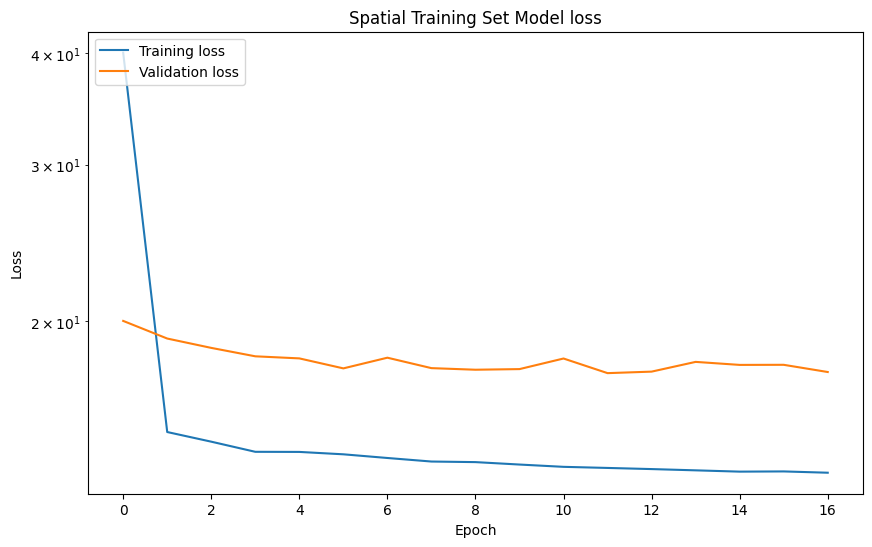

Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


In [55]:
m, errs = mod.run_model(rnn_dat)

In [56]:
errs.mean()

2.9371844100586535

In [57]:
params

{'n_features': 8,
 'timesteps': 12,
 'batch_size': 32,
 'hidden_layers': ['dense', 'lstm', 'dense', 'dense'],
 'hidden_units': [64, 32, 32, 16],
 'hidden_activation': ['relu', 'tanh', 'relu', 'relu'],
 'dropout': 0.2,
 'recurrent_dropout': 0.2,
 'output_layer': 'dense',
 'output_activation': 'linear',
 'output_dimension': 1,
 'learning_rate': 0.001,
 'early_stopping_patience': 5,
 'epochs': 30,
 'reset_states': True,
 'bmin': 10,
 'bmax': 200,
 'batch_schedule_type': 'step',
 'estep': 5,
 'features_list': ['Ed', 'Ew', 'solar', 'wind', 'rain', 'lon', 'lat', 'elev'],
 'scaler': 'standard',
 'time_fracs': [0.8, 0.1, 0.1],
 'space_fracs': [0.8, 0.1, 0.1],
 'stateful': True,
 'verbose_fit': True,
 'verbose_weights': True,
 'return_sequences': True,
 'batch_shape': (32, 12, 8),
 'loc_batch_reset': 147}

## RNN

In [ ]:
import importlib 
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN

In [ ]:
params = read_yml("params.yaml", subkey="lstm")
params = RNNParams(params)
params.update({
    'dense_layers': 2,
    'dense_units': 32
})

In [ ]:
params.update({'batch_schedule_type': 'step'})

In [ ]:
rnn_dat = rnn_data_wrap(combine_nested(train3), params)
reproducibility.set_seed(123)
rnn = RNN(params)

In [ ]:
rnn.model_train.summary()

In [ ]:
rnn.model_predict.summary()

In [ ]:
rnn.params

In [ ]:
rnn.model_train.fit(rnn_dat.X_train, rnn_dat.y_train, validation_data=(rnn_dat.X_val, rnn_dat.y_val), 
                    verbose=True, epochs=20)

In [ ]:
rnn.model_predict.set_weights(rnn.model_train.get_weights())

In [ ]:
rnn.model_predict.summary()

In [ ]:
rnn_dat.X_test.shape

In [ ]:
preds = rnn.model_predict.predict(rnn_dat.X_test)

In [ ]:
preds.shape

In [ ]:
rnn_dat.X_test.shape

In [ ]:
squared_diff = np.square(preds - rnn_dat.y_test)
mse = np.mean(squared_diff, axis=(1, 2))
errs = np.sqrt(mse)
errs.mean()

## Phys Initialized

In [ ]:
params.update({
    'epochs':100,
    'dense_layers': 0,
    'activation': ['relu', 'relu'],
    'phys_initialize': False,
    'dropout': [0,0],
    'space_fracs': [.8, .1, .1],
    'scaler': None
})

In [ ]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import rnn_data_wrap

In [ ]:
params['scaler'] is None

In [ ]:
rnn_dat = rnn_data_wrap(combine_nested(train3), params)

In [ ]:
reproducibility.set_seed()
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat)

In [ ]:
rnn.model_train.summary()

In [ ]:
errs.mean()

In [ ]:
rnn_dat.X_train[:,:,0].mean()

In [ ]:
rnn_dat['features_list']

## LSTM

In [ ]:
import importlib 
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN_LSTM

In [ ]:
params = read_yml("params.yaml", subkey="lstm")
params = RNNParams(params)

In [ ]:
rnn_dat = rnn_data_wrap(combine_nested(train3), params)

In [ ]:
params.update({
    'loc_batch_reset': rnn_dat.n_seqs # Used to reset hidden state when location changes for a given batch
})

In [ ]:
from moisture_rnn import ResetStatesCallback, EarlyStoppingCallback
params.update({'epochs': 50, 'learning_rate': 0.001, 'verbose_fit': True, 'rnn_layers': 2, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 10,
              'activation': ['tanh', 'tanh'], 'features_list': rnn_dat.features_list,
              'batch_schedule_type':'step', 'bmin': 10, 'bmax':rnn_dat.hours})
reproducibility.set_seed(123)
lstm = RNN_LSTM(params)

history = lstm.model_train.fit(rnn_dat.X_train, rnn_dat.y_train, 
                    batch_size = params['batch_size'], epochs=params['epochs'], 
                    callbacks = [ResetStatesCallback(params),
                                EarlyStoppingCallback(patience = 15)],
                   validation_data = (rnn_dat.X_val, rnn_dat.y_val))
              

In [ ]:
params = RNNParams(read_yml("params.yaml", subkey="lstm"))
params.update({'epochs': 50, 'learning_rate': 0.001, 'verbose_fit': True, 'rnn_layers': 2, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 10,
              'activation': ['tanh', 'tanh'], 'features_list': rnn_dat.features_list,
              'batch_schedule_type':'step', 'bmin': 10, 'bmax':rnn_dat.hours})
rnn_dat = rnn_data_wrap(combine_nested(train3), params)
params.update({
    'loc_batch_reset': rnn_dat.n_seqs # Used to reset hidden state when location changes for a given batch
})
reproducibility.set_seed(123)
lstm = RNN_LSTM(params)
m, errs = lstm.run_model(rnn_dat)

In [ ]:
errs.mean()

In [ ]:
params = RNNParams(read_yml("params.yaml", subkey="rnn"))
rnn_dat = rnn_data_wrap(combine_nested(train3), params)

In [ ]:
reproducibility.set_seed(123)
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat)

In [ ]:
errs.mean()